# Virtual Screening - PubChem - Acetylcholinesterase (AChE)

## Objetivos

- Realize triagem virtual no PubChem usando abordagem baseada em ligante
- Aplique filtros para priorizar a lista de ocorrências de triagem virtual.

In this notebook, we perform virtual screening against PubChem using a set of known ligands for muscle glycogen phosphorylase.  Compound filters will be applied to identify drug-like compounds and unique structures in terms of canonical SMILES will be selected to remove redundant structures.  For some top-ranked compounds in the list, their binding mode will be predicted using molecular docking (which will be covered in a separate assignment).

## 1. Read known ligands from a file.

As a starting point, let's download a set of known ligands against Acetylcholinesterase (AChE).  These data are obtained from the DUD-E (Directory of Useful Decoys, Enhanced) data sets (http://dude.docking.org/), which contain known actives and inactives for 102 protein targets.  The DUD-E sets are widely used in benchmarking studies that compare the performance of different virtual screening approaches (https://doi.org/10.1021/jm300687e).

Go to the DUD-E target page (http://dude.docking.org/targets) and find muscle glycogen phosphorylase (Target Name: PYGM, PDB ID: 1c8k) from the target list.  Clicking the target name "PYGM" directs you to the page that lists various files (http://dude.docking.org/targets/pygm).  Download file "**actives_final.ism**", which contains the SMILES strings of known actives.  Rename the file name as "**pygm_1c8k_actives.ism**".  \[Open the file in WordPad or other text viewer/editor to check the format of this file\].

In [1]:
import pandas as pd

In [2]:
colnames = ['smiles','dat', 'id']
df_act = pd.read_csv("../dataset/formats/actives_final.ism", sep=" ", names=colnames)
df_act.head(5)

,smiles,dat,id
0,Clc5ccc4c(NCCCCCNC(=O)CCCc1c[nH]c2ccccc12)c3CC...,374466,CHEMBL225021
1,CC(C)(C)c1cccc(C(=O)C(F)(F)F)c1,142855,CHEMBL89354
2,Clc5cc(Cl)c4c(NCCCCCCC(=O)NCCc1c[nH]c2ccccc12)...,335625,CHEMBL199585
3,Clc5ccc4c(NCCCCCCCNC(=O)CCc1c[nH]c2ccccc12)c3C...,374504,CHEMBL225198
4,CNC(=O)Oc4cccc(CN(C)CCCOc3ccc2c(=O)c1cccnc1oc2...,213761,CHEMBL131827


In [3]:
print(len(df_act))    # Show how many structures are in the "data frame"

453


## 2. Similarity Search against PubChem

Now, let's perform similarity search against PubChem using each known active compound as a query.  There are a few things to mention in this step:

- The isomeric SMILES string is available for each query compound. This string will be used to specify the input structure, so HTTP POST should be used.  (Please review lecture02-structure-inputs.ipynb)

- During PubChem's similarity search, molecular similarity is evaluated using the **PubChem fingerprints** and **Tanimoto** coefficient.  By default, similarity search will return compounds with Tanimoter scores of **0.9 or higher**.  While we will use the default threshold in this practice, it is noteworthy that it is adjustable.  If you use a higher threshold (e.g., 0.99), you will get a fewer hits, which are too similar to the query compounds.  If you use a lower threshold (e.g., 0.88), you will get more hits, but they will include more false positives.

- PubChem's similarity search does **not** return the similarity scores between the query and hit compounds.  Only the hit compound list is returned, which makes it difficult to rank the hit compounds for compound selection.  To address this issue, for each hit compound, we compute **the number of query compounds that returned that compound as a hit.**  \[Because we are using multiple query compounds for similarity search, it is possible for different query compounds to return the same compound as a hit.  That is, the hit compound may be similar to multiple query compounds.  The underlying assumption is that hit compounds returned multiple times from different queries are more likely to be active than those returned only once from a single query.\]

- Add "time.sleep()" to avoid overloading PubChem servers and getting blocked.

In [4]:
smiles_act = df_act.smiles.to_list()

In [5]:
import time
import requests

prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

cids_hit = dict()

for idx, mysmiles in enumerate(smiles_act) :
    
    mydata = { 'smiles' : mysmiles }
    
    url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt"
    res = requests.post(url, data=mydata)

    if ( res.status_code == 200 ) :
        cids = res.text.split()
        cids = [ int(x) for x in cids ]    # Convert CIDs from string to integer.
    else :
        print("Error at", idx, ":", df_act.loc[idx,'id'], mysmiles )
        print(res.status_code)
        print(res.content)
    
    for mycid in cids:
        cids_hit[mycid] = cids_hit.get(mycid, 0) + 1
    
    time.sleep(0.2)

In [6]:
len(cids_hit)    # Show the number of compounds returned from any query.

159470

In the above code cells, the returned hits are stored in a dictionary, along with the number of times they are returned.  Let's print the top 10 compounds that are returned the most number of times from the search.

In [7]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :

    if v == 10 : 
        break
    
    print(v, k) # Print (frequency, CID)
    

0 (33, 154409533)
1 (33, 88265278)
2 (33, 53437291)
3 (33, 44531955)
4 (33, 44387824)
5 (33, 24879379)
6 (33, 23299023)
7 (33, 11800131)
8 (33, 11410045)
9 (33, 10744885)


## 3. Exclude the query compounds from the hits

In the previous step, we repeated similarity searches using multiple query molecules.  This may result in a query molecule being returned as a hit from similarity search using another query molecule.  Therefore, we want to check if the hit compound list has any query compounds and if any, we want to remove them.  Below, we search PubChem for compounds identical to the query molecules and remove them from the hit compound list.<p>
Note that the identity_type parameter in the PUG-REST request is set to "**same_connectivity**", which will return compounds with the same connectivity with the query molecule (ignoring stereochemistry and isotope information).  The default for this parameter is "same_stereo_isotope", which returns compounds with the same stereochemistry AND isotope information.

In [8]:
cids_query = dict()

for idx, mysmiles in enumerate(smiles_act) :
    
    mydata = { 'smiles' : mysmiles }
    url = prolog + "/compound/fastidentity/smiles/cids/txt?identity_type=same_connectivity"
    res = requests.post(url, data=mydata)

    if ( res.status_code == 200 ) :
        cids = res.text.split()
        cids = [ int(x) for x in cids]
    else :
        print("Error at", idx, ":", df_act.loc[idx,'id'], mysmiles )
        print(res.status_code)
        print(res.content)
       
    for mycid in cids:
        cids_query[mycid] = cids_query.get(mycid, 0) + 1
    
    time.sleep(0.2)

Error at 294 : CHEMBL1085030 CN(CCOCCNC(=S)NC(=O)c1ccc3c(c1)c(=O)c2ccccc23)Cc4ccccc4
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
Error at 296 : CHEMBL100819 CN(CCOCCNC(=S)NC(=O)c3ccc2c(=O)c1ccccc1c2c3)Cc4ccccc4
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
Error at 311 : CHEMBL273051 O=C(CON=N(=O)N1CCCC1)NCCCNc3c2CCCCc2nc4ccccc34
500
b'Status: 500\nCode: PUGREST.ServerError\nMessage: Identity search status indicates failure\n'
Error at 361 : CHEMBL260964 O=C(CON=N(=O)N1CCCC1)NCCCCNc3c2CCCCc2nc4ccccc34
500
b'Status: 500\nCode: PUGREST.ServerError\nMessage: Identity search status indicates failure\n'
Error at 424 : CHEMBL349694 O=C(NC(=S)NCCC2CCN(Cc1ccccc1)CC2)c3ccc5c(c3)c(=O)c4ccccc45
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'


In [9]:
len(cids_query.keys())    # Show the number of CIDs that represent the query compounds.

886

Now remove the query compounds from the hit list (if they are found in the list)

In [10]:
for mycid in cids_query.keys() :
    
    cids_hit.pop(mycid, None)

In [11]:
len(cids_hit)

158597

Print the top 10 compounds in the current hit list and compare them with the old ones.

In [12]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :
    
    if v == 10 : 
        break
    
    print(v, k)    # Print (frequency, CID)


0 (33, 154409533)
1 (33, 88265278)
2 (33, 53437291)
3 (33, 44531955)
4 (33, 44387824)
5 (33, 24879379)
6 (33, 23299023)
7 (33, 11410045)
8 (33, 10625415)
9 (33, 9984054)


## 4. Filtering out non-drug-like compounds

In this step, non-drug-like compounds are filtered out from the list.  To do that, four molecular properties are downloaded from PubChem and stored in CSV.

In [13]:
chunk_size = 100

if ( len(cids_hit) % chunk_size == 0 ) :
    num_chunks = len(cids_hit) // chunk_size 
else :
    num_chunks = len(cids_hit) // chunk_size + 1

cids_list = list(cids_hit.keys())
    
print("# Number of chunks:", num_chunks )

csv = ""   #sets a variable called csv to save the comma separated output

for i in range(num_chunks) :
    
    print(i, end=" ")
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)

    cids_str = ",".join([ str(x) for x in cids_list[idx1:idx2] ]) # build pug input for chunks of data
    url = prolog + "/compound/cid/" + cids_str + "/property/HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES/csv"
    
    res = requests.get(url)
    
    if ( i == 0 ) : # if this is the first request, store result in empty csv variable
        csv = res.text 
    else :          # if this is a subsequent request, add the request to the csv variable adding a new line between chunks
        csv = csv + "\n".join(res.text.split()[1:]) + "\n" 
      
    time.sleep(0.2)

#print(csv)

# Number of chunks: 1586
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 2

Downloaded data (in CSV) are loaded into a pandas data frame.

In [14]:
from io import StringIO

csv_file = StringIO(csv)

df_raw = pd.read_csv(csv_file, sep=",")

df_raw.shape    # Show the shape (dimesnion) of the data frame

(158597, 7)

In [15]:
df_raw.head(5)    # Show the first 5 rows of the data frame

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
0,11669798,3,3,461.0,6.2,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCNC(=O)C...,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCNC(=O)C...
1,11478767,3,3,582.0,7.7,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...
2,11465956,3,3,489.0,7.1,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...
3,11316986,3,3,454.6,5.8,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCNC(=O)CCC4=CN...,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCNC(=O)CCC4=CN...
4,11156231,3,4,497.7,5.5,CN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC(=O)CCC4...,CN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC(=O)CCC4...


Note that some compounds do not have computed XLogP values (because XLogP algorithm cannot handle inorganic compounds, salts, and mixtures) and we want to remove them.

In [16]:
df_raw.isna().sum()    # Check if there are any NULL values.

CID                       0
HBondDonorCount           0
HBondAcceptorCount        0
MolecularWeight           0
XLogP                 16088
CanonicalSMILES           0
IsomericSMILES            0
dtype: int64

In [17]:
len(df_raw)    # Check the number of rows (which is equals to the number of CIDs)

158597

For convenience, add the information contained in the **cids_hit** dictionary to this data frame

In [18]:
# First load the cids_hit dictionary into a data frame.
df_freq = pd.DataFrame( cids_hit.items(), columns=['CID','HitFreq'])
df_freq.head(5)

,CID,HitFreq
0,11669798,16
1,11478767,10
2,11465956,16
3,11316986,11
4,11156231,10


In [19]:
# Double-check if the data are loaded correctly
# Compare the data with those from Cell [12]
df_freq.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HitFreq
5268,154409533,33
5518,88265278,33
6304,53437291,33
5763,44531955,33
4746,44387824,33
4761,24879379,33
5777,23299023,33
4550,11410045,33
4507,10625415,33
5913,9984054,33


In [20]:
# Create a new data frame called "df" by joining the df and df_freq data frames
df = df_raw.join(df_freq.set_index('CID'), on='CID')
df.shape

(158597, 8)

In [21]:
df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq
5268,154409533,2,5,499.6,7.1,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCCN(CCCN)C4=...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCCN(CCCN)C4=...,33
5518,88265278,2,5,499.6,6.5,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCCNCCCN)C4=...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCCNCCCN)C4=...,33
6304,53437291,3,6,556.7,7.3,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCN(CCCCN)CCC...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCN(CCCCN)CCC...,33
5763,44531955,2,4,550.7,10.0,C1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)NCCCCCCCCNC4...,C1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)NCCCCCCCCNC4...,33
4746,44387824,2,5,529.7,8.1,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,33
4761,24879379,2,5,547.8,8.3,C=CCN(CCCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5...,C=CCN(CCCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5...,33
5777,23299023,2,5,499.6,6.5,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCNCCCCN)C4=...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCNCCCCN)C4=...,33
4550,11410045,2,5,533.7,8.0,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,33
4507,10625415,2,4,506.7,9.1,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCNC4=C5CCCC...,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCNC4=C5CCCC...,33
5913,9984054,2,4,516.7,9.7,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCCNC4=C5C=C...,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCCNC4=C5C=C...,33


Now identify and remove those compounds that satisfy all criteria of Lipinski's rule of five.

In [22]:
len(df[ df['HBondDonorCount'] <= 5 ])

158360

In [23]:
len(df[ df['HBondAcceptorCount'] <= 10 ])

157829

In [24]:
len(df[ df['MolecularWeight'] <= 500 ])

146837

In [25]:
len(df[ df['XLogP'] < 5 ])

119056

In [26]:
df = df[ ( df['HBondDonorCount'] <= 5) &
         ( df['HBondAcceptorCount'] <= 10 ) &
         ( df['MolecularWeight'] <= 500 ) &
         ( df['XLogP'] < 5 ) ]

In [27]:
len(df)

117379

## 5. Draw the structures of the top 10 compounds

Let's check the structure of the top 10 compounds in the hit list.

In [28]:
cids_top = df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

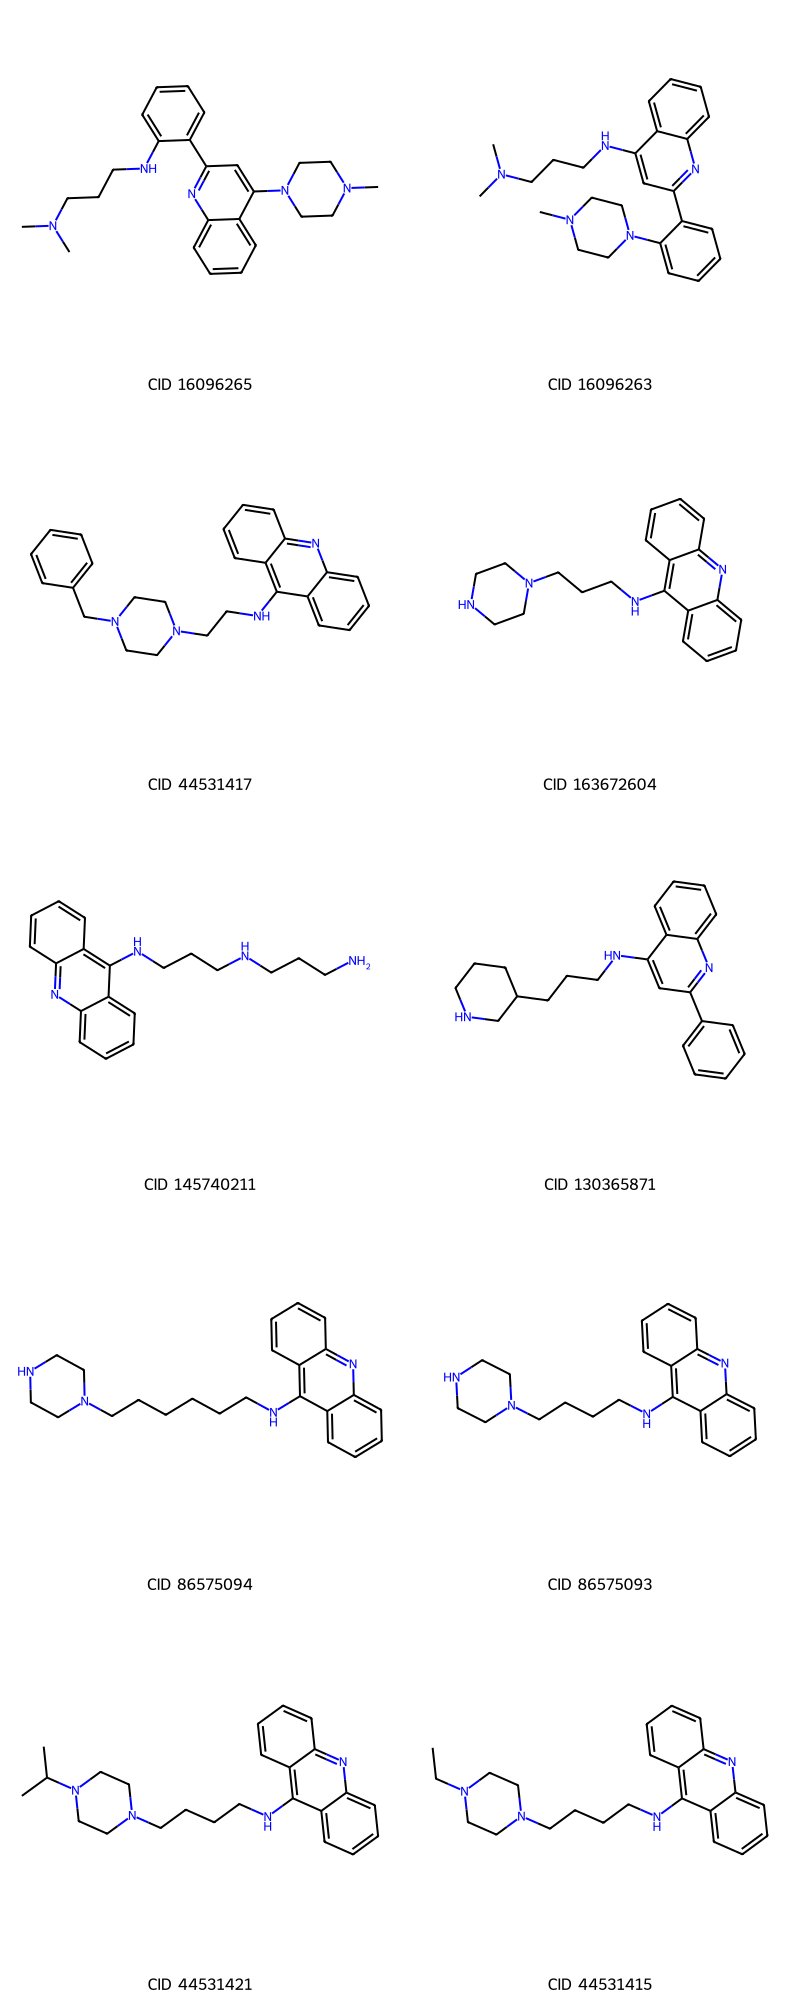

In [29]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].IsomericSMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,400), legends=mylegends)
display(img)

An important observation from these images is that the hit list contains multiple compounds with the same connectivity.  For example, CIDs 93077065 and 93077064 are stereoisomers of each other and CID 53013349 has the same connectivity as the two CIDs, but with its stereocenter being unspecified. When performing a screening with limited resources in the early stage of drug discovery, you may want to test as diverse molecules as possible, avoiding testing too similar structures.

To do so, let's look into PubChem's canonical SMILES strings, which do not encode the stereochemisry and isotope information.  Chemicals with the same connectivity but with different stereochemistry/isotopes should have the same canonical SMILES.  In the next section, we select unique compounds in terms of canonical SMILES to reduce the number of compounds to screen.

## 6. Extract unique compounds in terms of canonical SMILES

The next few cells show how to get unique values within a column (in this case, unique canonical SMILES).

In [30]:
len(df)

117379

In [31]:
len(df.CanonicalSMILES.unique())

101100

In [32]:
canonical_smiles = df.CanonicalSMILES.unique()

In [33]:
df[ df.CanonicalSMILES == canonical_smiles[0] ]

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq
6,16723801,1,2,389.9,4.2,C1=CC=C2C(=C1)C(=CN2CC3=CC=C(C=C3)Cl)CCC(=O)NC...,C1=CC=C2C(=C1)C(=CN2CC3=CC=C(C=C3)Cl)CCC(=O)NC...,9


In [34]:
df[ df.CanonicalSMILES == canonical_smiles[1] ]

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq
14,4782931,2,1,326.8,4.1,C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl,C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl,9


In [35]:
df[ df.CanonicalSMILES == canonical_smiles[1] ].IsomericSMILES.to_list()

['C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl']

Now let's generate a list of unique compounds in terms of canonical SMILES.  If multiple compounds have the same canonical SMILES, the one that appears very first will be included in the unique compound list.

In [36]:
idx_to_include = []

for mysmiles in canonical_smiles :

    myidx = df[ df.CanonicalSMILES == mysmiles ].index.to_list()[0]
    
    idx_to_include.append( myidx )

In [37]:
len(idx_to_include)

101100

In [38]:
# Create a new column 'Include' 
# All values initialized to 0 (not include)
df['Include'] = 0
df['Include'].sum()

0

In [39]:
# Now the "Include" column's value is modified if the record is in the idx_to_include list.
df.loc[idx_to_include,'Include'] = 1
df['Include'].sum()

101100

In [40]:
df[['CID','Include']].head(10)

,CID,Include
6,16723801,1
14,4782931,1
39,145950271,1
46,118705964,1
55,42743586,1
56,42743569,1
60,9978527,1
61,6457960,1
62,2704817,1
63,168280844,1


Now draw the top 10 unique compounds (in terms of canonical SMILES). Note the, the structure figures are drawn using isomeric SMILES, but canonical SMILES strings could be used.

In [41]:
cids_top = df[ df['Include'] == 1].sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

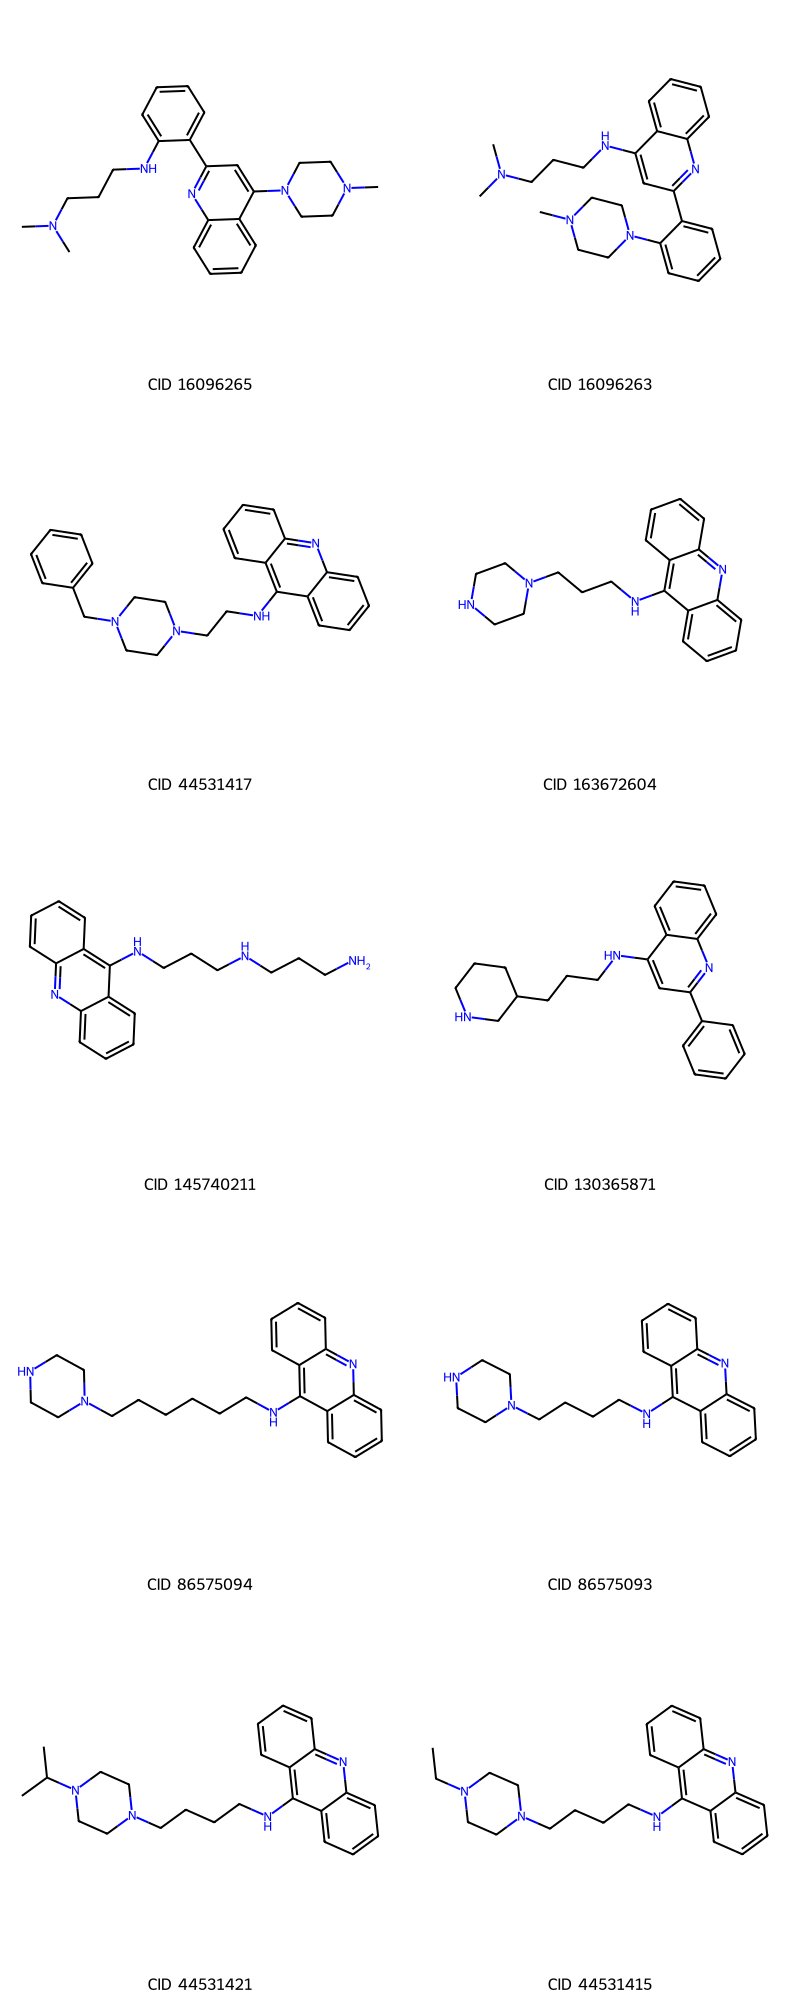

In [42]:
mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].IsomericSMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,400), legends=mylegends)
display(img)

## 7. Saving molecules in files

Now save the molecules in the cids_top list in files, which will be used in molecular docking experiments.  For simplicity, we will use only the **top 3** compounds in the list.

In [43]:
from rdkit.Chem import AllChem

for idx, mycid in enumerate( cids_top ) :

    if idx == 3 :
        break
        
    mysmiles = df[ df['CID'] == mycid ].IsomericSMILES.item()

    mymol = Chem.MolFromSmiles(mysmiles)
    mymol = Chem.AddHs(mymol)
    AllChem.EmbedMolecule(mymol)
    AllChem.MMFFOptimizeMolecule(mymol)

    filename = "pygm_lig" + str(idx) + "_" + str(mycid) + ".mol"
    Chem.MolToMolFile(mymol, filename)


To save all data in the **df** data frame (in CSV) 

In [44]:
df.to_csv('pygm_df.csv')

In [45]:
df = pd.read_csv("pygm_df.csv", delimiter= ",", error_bad_lines=False)

/home/note/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117379 entries, 0 to 117378
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          117379 non-null  int64  
 1   CID                 117379 non-null  int64  
 2   HBondDonorCount     117379 non-null  int64  
 3   HBondAcceptorCount  117379 non-null  int64  
 4   MolecularWeight     117379 non-null  float64
 5   XLogP               117379 non-null  float64
 6   CanonicalSMILES     117379 non-null  object 
 7   IsomericSMILES      117379 non-null  object 
 8   HitFreq             117379 non-null  int64  
 9   Include             117379 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 9.0+ MB


In [47]:
df.shape

(117379, 10)

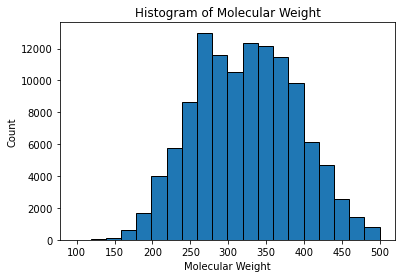

Count: [6.0000e+00 2.7000e+01 1.1100e+02 6.0200e+02 1.6910e+03 4.0130e+03
 5.7420e+03 8.6400e+03 1.2993e+04 1.1621e+04 1.0534e+04 1.2346e+04
 1.2148e+04 1.1452e+04 9.8310e+03 6.1160e+03 4.6940e+03 2.5380e+03
 1.4430e+03 8.3100e+02]
Molecular Weight: [ 98.17   118.2515 138.333  158.4145 178.496  198.5775 218.659  238.7405
 258.822  278.9035 298.985  319.0665 339.148  359.2295 379.311  399.3925
 419.474  439.5555 459.637  479.7185 499.8   ]


In [63]:
import matplotlib.pyplot as plt

# Suponha que 'df' seja o DataFrame que contém seus dados
contagens, bordas, _ = plt.hist(df['MolecularWeight'], bins=20, edgecolor='k')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.title('Histogram of Molecular Weight')
plt.show()

# contagens contém as contagens dos bins
print("Count:", contagens)

# bordas contém as bordas dos bins
print("Molecular Weight:", bordas)

#### Os dados indicam que a maioria das observações tem um peso molecular entre 298.985 e 319.0665, com 12.346 observações nesse intervalo. Além disso, você pode observar como as contagens de observações variam à medida que o peso molecular aumenta ou diminui.

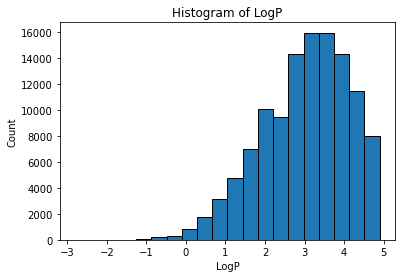

Count: [4.0000e+00 3.0000e+00 4.0000e+00 1.8000e+01 5.6000e+01 1.7800e+02
 3.1500e+02 8.2300e+02 1.7430e+03 3.1090e+03 4.7400e+03 6.9500e+03
 1.0054e+04 9.4650e+03 1.4338e+04 1.5938e+04 1.5937e+04 1.4267e+04
 1.1434e+04 8.0030e+03]
Molecular Weight: [-2.8   -2.415 -2.03  -1.645 -1.26  -0.875 -0.49  -0.105  0.28   0.665
  1.05   1.435  1.82   2.205  2.59   2.975  3.36   3.745  4.13   4.515
  4.9  ]


In [64]:
# Suponha que 'df' seja o DataFrame que contém seus dados
contagens, bordas, _ = plt.hist(df['XLogP'], bins=20, edgecolor='k')
plt.xlabel('LogP')
plt.ylabel('Count')
plt.title('Histogram of LogP')
plt.show()

# contagens contém as contagens dos bins
print("Count:", contagens)

# bordas contém as bordas dos bins
print("Molecular Weight:", bordas)

#### os dados indicam que a maioria das observações tem um LogP entre 1.05 e 1.435, com 4.740 observações nesse intervalo. Além disso, você pode observar como as contagens de observações variam à medida que o LogP aumenta ou diminui

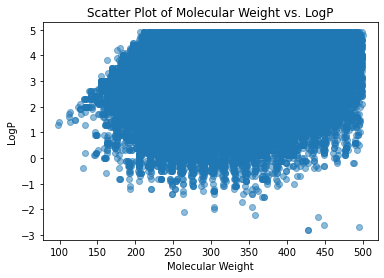

In [51]:
import matplotlib.pyplot as plt

plt.scatter(df['MolecularWeight'], df['XLogP'], alpha=0.5)
plt.xlabel('Molecular Weight')
plt.ylabel('LogP')
plt.title('Scatter Plot of Molecular Weight vs. LogP')
plt.show()

#### A dispersão dos pontos no gráfico mostra como as duas variáveis MolecularWeight e XLogP estão relacionadas. O gráfico ajuda a identificar tendências, padrões ou correlações entre as variáveis. Como os pontos estão concentrados em uma área específica, isso pode indicar uma correlação ou relação entre as duas variáveis. 

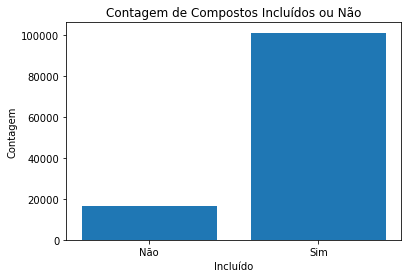

In [53]:
count_include = df['Include'].value_counts()
plt.bar(count_include.index, count_include.values)
plt.xlabel('Incluído')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.title('Contagem de Compostos Incluídos ou Não')
plt.show()

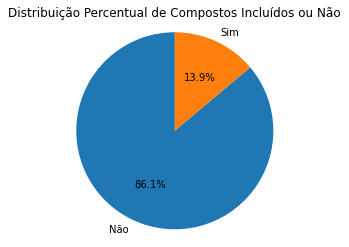

In [54]:
count_include = df['Include'].value_counts()
plt.pie(count_include, labels=['Não', 'Sim'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribuição Percentual de Compostos Incluídos ou Não')
plt.show()

In [55]:
df_incluidos = df[df['Include'] == 1]

In [56]:
df_incluidos.shape

(101100, 10)

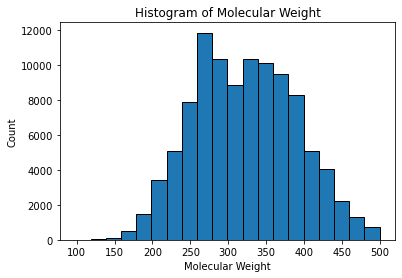

In [57]:
import matplotlib.pyplot as plt
# Suponha que 'df' seja o DataFrame que contém seus dados
plt.hist(df_incluidos['MolecularWeight'], bins=20, edgecolor='k')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.title('Histogram of Molecular Weight')
plt.show()

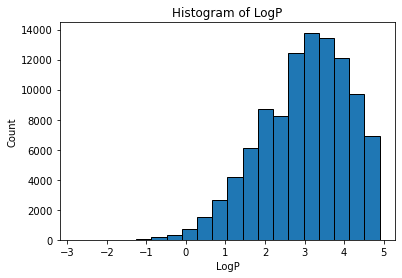

In [58]:
import matplotlib.pyplot as plt

plt.hist(df_incluidos['XLogP'], bins=20, edgecolor='k')
plt.xlabel('LogP')
plt.ylabel('Count')
plt.title('Histogram of LogP')
plt.show()

In [65]:
df_incluidos.to_csv('../dataset/formats/vs_acetylcholinesterase_final.csv')

In [66]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df_incluidos,'CanonicalSMILES','Molecule',includeFingerprints=True)

[08:42:53] Explicit valence for atom # 20 Cl, 3, is greater than permitted
[08:43:05] Explicit valence for atom # 6 Br, 3, is greater than permitted
[08:43:09] Explicit valence for atom # 30 Cl, 3, is greater than permitted
/home/note/anaconda3/lib/python3.7/site-packages/rdkit/Chem/PandasTools.py:382: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda smiles: _MolPlusFingerprint(Chem.MolFromSmiles(smiles)))


In [67]:
vs = df_incluidos.dropna(subset=['Molecule'])

In [68]:
vs.head(5)

,Unnamed: 0,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq,Include,Molecule
0,6,16723801,1,2,389.9,4.2,C1=CC=C2C(=C1)C(=CN2CC3=CC=C(C=C3)Cl)CCC(=O)NC...,C1=CC=C2C(=C1)C(=CN2CC3=CC=C(C=C3)Cl)CCC(=O)NC...,9,1,<rdkit.Chem.rdchem.Mol object at 0x7f0e1897b390>
1,14,4782931,2,1,326.8,4.1,C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl,C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl,9,1,<rdkit.Chem.rdchem.Mol object at 0x7f0e188e8150>
2,39,145950271,4,3,450.0,3.6,C1CN(CCC1NC(=O)C(CC2=CNC3=CC=CC=C32)N)CC4=CNC5...,C1CN(CCC1NC(=O)[C@H](CC2=CNC3=CC=CC=C32)N)CC4=...,11,1,<rdkit.Chem.rdchem.Mol object at 0x7f0e188e82d0>
3,46,118705964,2,4,448.0,4.3,CN1CCN(CC1)C(=O)C(CC2=CNC3=CC=CC=C32)NC4=C5C=C...,CN1CCN(CC1)C(=O)[C@H](CC2=CNC3=CC=CC=C32)NC4=C...,12,1,<rdkit.Chem.rdchem.Mol object at 0x7f0e188e8570>
4,55,42743586,2,3,381.9,4.7,C1=CC=C(C=C1)CCC(=O)NCCCCNC2=C3C=CC(=CC3=NC=C2)Cl,C1=CC=C(C=C1)CCC(=O)NCCCCNC2=C3C=CC(=CC3=NC=C2)Cl,5,1,<rdkit.Chem.rdchem.Mol object at 0x7f0e188e8630>


In [69]:
vs.shape

(101097, 11)

In [70]:
vs.columns

Index(['Unnamed: 0', 'CID', 'HBondDonorCount', 'HBondAcceptorCount',
       'MolecularWeight', 'XLogP', 'CanonicalSMILES', 'IsomericSMILES',
       'HitFreq', 'Include', 'Molecule'],
      dtype='object')

In [71]:
PandasTools.WriteSDF(vs, '../dataset/formats/virtual_molecuke.sdf', molColName='Molecule', properties=list(df.columns))

In [1]:
import numpy as np
import pandas as pd
from padelpy import from_smiles
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import DataStructs
from padelpy import from_smiles, from_mdl, from_sdf, padeldescriptor
import sirms as si
import seaborn as sns
import matplotlib

## RDKIT Descriptors

In [2]:
mols = [x for x in  Chem.SDMolSupplier("../dataset/formats/virtual_molecuke.sdf") if x is not None]
rdkit_2d_desc = []
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()
for i in range(len(mols)):
    ds = calc.CalcDescriptors(mols[i])
    rdkit_2d_desc.append(ds)
df = pd.DataFrame(rdkit_2d_desc,columns=header)
df.to_csv('../descriptors/generate/rdkit/virtual_screening_rdkit_ml_descriptors.csv')

## Morgan Descriptors

In [4]:
from math import floor
#Rdkit: coleção de quiminformática e software de aprendizado de máquina escrito em C++ e Python de Código Aberto.
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from collections import Counter


# Calculando os descritores fingerprints de Harry Morgan (vetores de bits).
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Adicionando os 4829 componentes e os 2048 dados referetens aos descritores de Morgan
desc = vs.Molecule.apply(calcfp)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.to_csv('../descriptors/generate/sirms/virtual_screening_morgan_descriptors.csv', index=False)
print(desc.shape)

NameError: name 'vs' is not defined

## Sirms Descriptors

In [3]:
#! pip install sirms
! sirms -i ../dataset/formats/virtual_molecuke.sdf -o ../descriptors/generate/sirms/virtual_screening_sirms_descriptors.txt

## PADEL Descriptors

In [ ]:
padeldescriptor(mol_dir='../dataset/formats/virtual_molecuke.sdf', d_file='../descriptors/generate/padel/virtual_screening_padel_descriptors.csv', d_2d=True)